In [9]:
import SimpleITK as sitk
import torch

import numpy as np
from utils import trim_state_dict_name

%matplotlib inline
from matplotlib import pyplot as plt

In [25]:
latent_dim = 1024
save_step = 80000
batch_size = 1
img_size = 256
num_class = 0
exp_name = "HA_GAN_run2"

## Load model

In [26]:
if img_size == 256:
    from models.Model_HA_GAN_256 import Generator, Encoder, Sub_Encoder
elif img_size == 128:
    from models.Model_HA_GAN_128 import Generator, Encoder, Sub_Encoder

G = Generator(mode='eval', latent_dim=latent_dim, num_class=num_class).cuda()

E = Encoder().cuda()
Sub_E = Sub_Encoder(latent_dim=latent_dim).cuda()

ckpt_path = "./checkpoint/"+exp_name+"/G_iter"+str(save_step)+".pth"
ckpt = torch.load(ckpt_path)['model']
ckpt = trim_state_dict_name(ckpt)
G.load_state_dict(ckpt)

ckpt_path = "./checkpoint/"+exp_name+"/E_iter"+str(save_step)+".pth"
ckpt = torch.load(ckpt_path)['model']
ckpt = trim_state_dict_name(ckpt)
E.load_state_dict(ckpt)

ckpt_path = "./checkpoint/"+exp_name+"/Sub_E_iter"+str(save_step)+".pth"
ckpt = torch.load(ckpt_path)['model']
ckpt = trim_state_dict_name(ckpt)
Sub_E.load_state_dict(ckpt)

print(exp_name, save_step, "step weights loaded.")
del ckpt

G = G.cuda()
E = E.cuda()
Sub_E = Sub_E.cuda()

G.eval()
E.eval()
Sub_E.eval()

torch.cuda.empty_cache()

HA_GAN_run2 80000 step weights loaded.


## Random generation

In [27]:
with torch.no_grad():
    z_rand = torch.randn((batch_size, latent_dim)).cuda()
    x_rand = G(z_rand,0)
    x_rand = x_rand.detach().cpu().numpy()
    x_rand = 0.5*x_rand+0.5 # rescale intensity to [0,1]

    x_rand = x_rand[0,0,:,:,:]

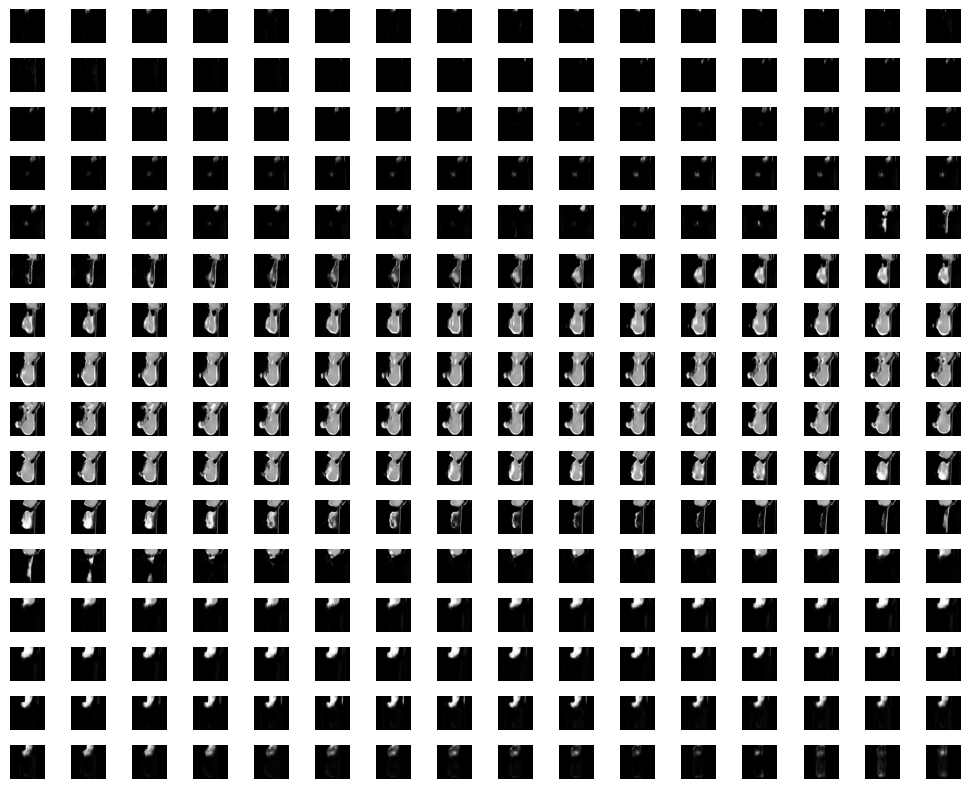

In [29]:

import math
n_slices = x_rand.shape[2]

n_cols = int(math.ceil(math.sqrt(n_slices)))
n_rows = int(math.ceil(n_slices / float(n_cols)))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 8))

for i, ax in enumerate(axes.flat):
    if i < n_slices:
        ax.imshow(x_rand[:, :, i], cmap='gray')
        ax.axis('off')
    else:
        ax.set_visible(False)

plt.tight_layout()
plt.show()


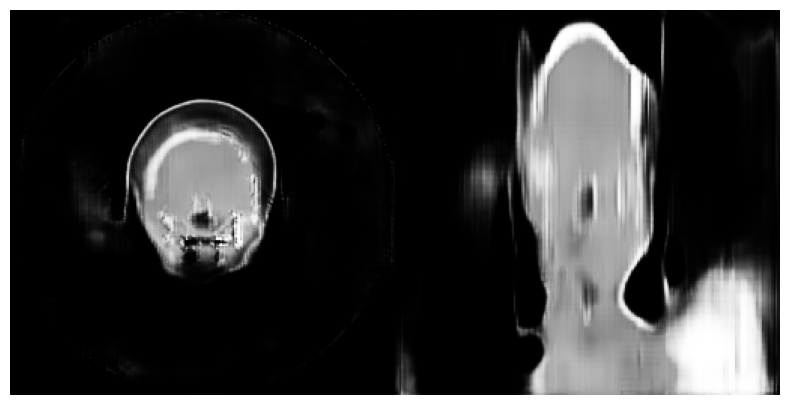

In [28]:
slice_idx = [127,120,101]
slice_x = np.flip(x_rand[slice_idx[0],:,:],0)
slice_y = np.flip(x_rand[:,slice_idx[1],:],0)
slice_z = np.flip(x_rand[:,:,slice_idx[2]],0)

result = np.concatenate([slice_x,slice_y],1)
plt.figure(figsize=(10,5))
plt.imshow(result, cmap="gray")
plt.axis('off')
plt.show()

### Save in NIFTI

In [6]:
import nibabel as nib

low_threshold = -1024
high_threshold = 600

x_rand_nifti = x_rand * (high_threshold-low_threshold) + low_threshold # rescale to [low_threshold, high_threshold]
x_rand_nifti = x_rand_nifti.astype(np.int16)

x_rand_nifti = nib.Nifti1Image(x_rand_nifti.transpose((2,1,0)),affine = np.eye(4))
nib.save(x_rand_nifti, "x_rand_nifti.nii.gz")

## Zoom-in region

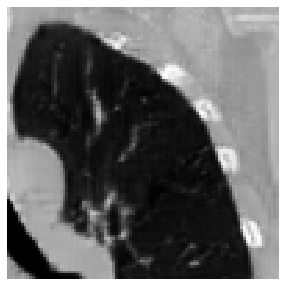

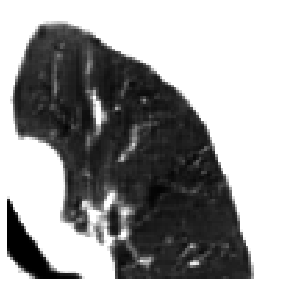

In [36]:
plt.figure(figsize=(5,5))
plt.imshow(slice_y[10:128-20,128:-30], cmap="gray")
plt.axis('off')
plt.show()

slice_y_threshold = slice_y[10:128-20,128:-30].copy()
slice_y_threshold = np.clip(slice_y_threshold, 0., (-250+1024)/(600+1024))

plt.figure(figsize=(5,5))
plt.imshow(slice_y_threshold, cmap="gray")
plt.axis('off')
plt.show()

## View in 3D

In [8]:
import holoviews as hv
from holoviews import opts
import xarray as xr
hv.extension('bokeh')

In [36]:
class Image:
    def __init__(self, image_array):
        self.image_array=image_array
        self.xr=None
    def get_xr(self):
        if self.xr is not None:
            return self.xr
        else:
            self.xr=xr.Dataset({'image': (['x','y','z'], self.image_array)},
                      coords={
                          'x':np.arange(img_size),
                          'y':np.arange(img_size),
                          'z':np.arange(img_size)
                      })
            return self.xr
        
def plot_on_grid(image):
    hv_image = hv.Dataset(image.get_xr())
    layout = (hv_image.to(hv.Image, ['y', 'x'], groupby=['z'], dynamic=True).opts(tools=['hover'])
              + hv_image.to(hv.Image, ['z', 'x'], groupby=['y'], dynamic=True).opts(tools=['hover'])
              + hv_image.to(hv.Image, ['z', 'y'], groupby=['x'], dynamic=True).opts(tools=['hover']))

    layout.opts(
        opts.Image(width=300, height=300, cmap="gray"))
    return layout


In [37]:
x_rand_img = Image(x_rand)
plot_on_grid(x_rand_img)